## Importing libraries

In [ ]:
!pip install torch torchmetrics torchaudio datasets transformers scikit-learn matplotlib wandb torchcodec

from datasets import load_dataset
from transformers import (
    AutoFeatureExtractor,
    AutoModelForAudioClassification,
)
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
from google.colab import drive
import os
from google.colab import userdata
import torch
import wandb

## Getting paths for metadata and getting a key for wandb

In [2]:
BASE_DIR = '/content/'

TEST_PATH  = os.path.join(BASE_DIR, 'test.csv')

wandb_kay = userdata.get('WANDB')

## Log in to wandb

In [ ]:
wandb.login(key=wandb_kay)

wandb.init(
    project="AST",
)


## Cloning your google drive

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


## Selecting the target directory

In [5]:
!rsync -a "/content/drive/MyDrive/audio_cls/" .

## Downloading a dataset

In [ ]:
dataset = load_dataset(
    "csv",
    data_files={
        "test" : TEST_PATH
    }
)
dataset

In [23]:
LABELS = ['siren', 'gunshot', 'explosion', 'casual']
label2id = {label: i for i, label in enumerate(LABELS)}
id2label = {i: label for i, label in enumerate(LABELS)}

## Fix paths for a google colab

In [24]:
DATA_DIR_TRAIN = "/content/train"
DATA_DIR_VALID = "/content/valid"
DATA_DIR_TEST  = "/content/test"

def fix_path_test(example):
    example["path"] = f"{DATA_DIR_TEST}/{example["path"]}"
    return example

def fix_label(example):
    example["labels"] = example.pop("target")
    return example

test_df  = dataset['test']
test_df  = test_df.map(fix_path_test)
test_df  = test_df.map(fix_label)

Map:   0%|          | 0/105 [00:00<?, ? examples/s]

Map:   0%|          | 0/105 [00:00<?, ? examples/s]

## Initial model

In [ ]:
MODEL_NAME = "MIT/ast-finetuned-audioset-10-10-0.4593"

feature_extractor = AutoFeatureExtractor.from_pretrained(MODEL_NAME)
model = AutoModelForAudioClassification.from_pretrained(MODEL_NAME)

model.eval()

## Mapping

In [ ]:
print("Model id2label:", model.config.id2label)

label_map = {
    'siren': 396,
    'gunshot': 427,
    'explosion': 426
}


## Downloading audio samples

In [27]:
def preprocess(batch):
    waveform, sr = librosa.load(batch["path"], sr=16000)
    inputs = feature_extractor(
        waveform,
        sampling_rate=16000,
        return_tensors="pt"
    )
    batch["input_values"] = inputs["input_values"].squeeze(0).tolist()
    return batch

test_df  = test_df.map(preprocess)

Map:   0%|          | 0/105 [00:00<?, ? examples/s]

## Inference

In [28]:
y_true = []
y_pred = []

for row in tqdm(test_df, desc="Inference"):
    x = torch.tensor(row["input_values"]).unsqueeze(0)

    with torch.no_grad():
        logits = model(x).logits
        pred_idx = torch.argmax(logits, dim=-1).item()

    if pred_idx == label_map['siren']:
        final_pred = 0
    elif pred_idx == label_map['gunshot']:
        final_pred = 1
    elif pred_idx == label_map['explosion']:
        final_pred = 2
    else:
        final_pred = 3

    y_true.append(row["labels"])
    y_pred.append(final_pred)

print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 macro:", f1_score(y_true, y_pred, average="macro"))
print("Precision macro:", precision_score(y_true, y_pred, average="macro"))
print("Recall macro:", recall_score(y_true, y_pred, average="macro"))

Inference: 100%|██████████| 105/105 [05:01<00:00,  2.87s/it]

Accuracy: 0.7142857142857143
F1 macro: 0.628210498409332
Precision macro: 0.854348826507133
Recall macro: 0.6247217222432739


## Make confusion matrix

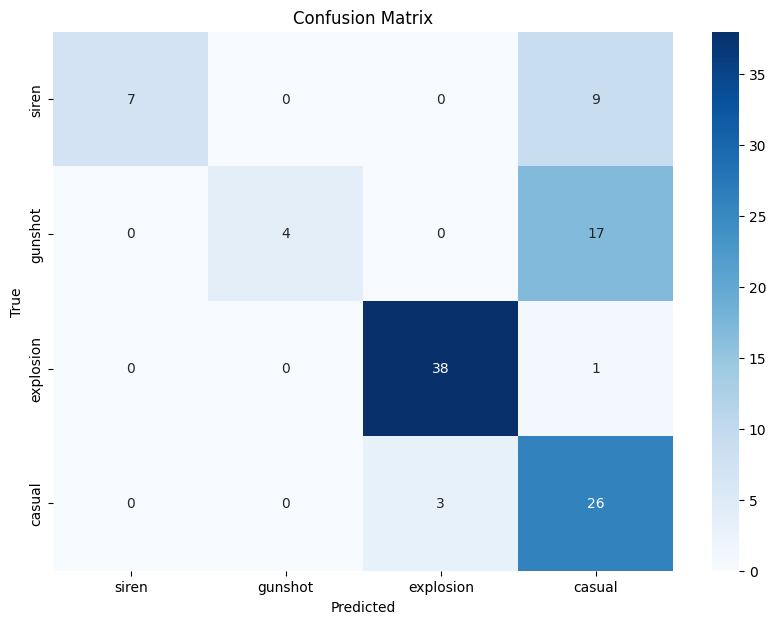

In [29]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=id2label.values(),
            yticklabels=id2label.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()